This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case.

In [ ]:
%%capture
!pip install git+https://github.com/corentinravoux/flip

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flip import fitter, plot_utils, utils, data_vector
from flip.covariance import covariance, contraction
from pkg_resources import resource_filename
flip_base = resource_filename("flip", ".")
data_path = os.path.join(flip_base, "data")
plt.style.use(os.path.join(data_path,"style.mplstyle"))

[ 000000.00 ]: 09-13 10:34  root            INFO     No pypower module detected, gridding with this method is unavailable
[ 000000.05 ]: 09-13 10:34  jax._src.xla_bridge INFO     Unable to initialize backend 'cuda': 
[ 000000.05 ]: 09-13 10:34  jax._src.xla_bridge INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000000.06 ]: 09-13 10:34  jax._src.xla_bridge INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
[ 000000.06 ]: 09-13 10:34  jax._src.xla_bridge WARNING  An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/tmp/ipykernel_963250/3995639268.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


# Select data

In [2]:
grid = pd.read_parquet(os.path.join(data_path,"density_data.parquet"))
grid_window = pd.read_parquet(os.path.join(data_path,"grid_window_m.parquet"))
coordinates_density = np.array([grid["ra"], grid["dec"], grid["rcom"]])
data_density = {'density': np.array(grid["density"]), 
                'density_error': np.array(grid["density_err"])}


DataDensity = data_vector.Dens(grid.rename(columns={'density_err': 'density_error', 'rcom': 'rcom_zobs'}).to_dict(orient='list'))


sn_data = pd.read_parquet(os.path.join(data_path,"velocity_data.parquet"))

coordinates_velocity = np.array([sn_data["ra"], sn_data["dec"], sn_data["rcom_zobs"]])
data_velocity = sn_data.to_dict("list")
for key in data_velocity.keys():
    data_velocity[key] = np.array(data_velocity[key])
data_velocity["velocity"] = data_velocity.pop("vpec")
data_velocity["velocity_error"] = np.zeros_like(data_velocity["velocity"])

data_velocity_true = {**sn_data.rename(columns={'vpec': 'velocity'}).to_dict(orient='list'), 
                      "velocity_error": np.zeros(len(sn_data["vpec"].values))}


# Create the True Vel data vector
DataTrueVel = data_vector.DirectVel(data_velocity_true)

# Create the Vel data vector
DataVel = data_vector.snia_vectors.VelFromSALTfit(sn_data.to_dict(orient='list'), vel_estimator='full')

data_full = {}
data_full.update(data_density)
data_full.update(data_velocity)

DensTrueVel = data_vector.DensVel(DataDensity, DataTrueVel)


sigmau_fiducial = 15.0
sigmag_fiducial = 3.0

ktt, ptt = np.loadtxt(os.path.join(data_path,"power_spectrum_tt.txt"))
kmt, pmt = np.loadtxt(os.path.join(data_path,"power_spectrum_mt.txt"))
kmm, pmm = np.loadtxt(os.path.join(data_path,"power_spectrum_mm.txt"))
power_spectrum_dict_bias = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2]]}
power_spectrum_dict = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2],[kmt, pmt * np.array(grid_window["window_mt"])],[ktt, ptt]],
                       "gv": [[kmt, pmt * np.array(grid_window["window_mt"])* utils.Du(kmt, sigmau_fiducial)],[ktt, ptt* utils.Du(kmt, sigmau_fiducial)]],
                       "vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial)**2]]}

# Fit with true velocities

In [3]:
size_batch=10_000
number_worker=8

covariance_fit = covariance.CovMatrix.init_from_flip(
    "adamsblake20",
    "full",
    power_spectrum_dict,
    coordinates_density=coordinates_density,
    coordinates_velocity=coordinates_velocity,
    size_batch=size_batch,
    number_worker=number_worker,
    additional_parameters_values=(sigmag_fiducial,),
)

/pscratch/sd/b/bastienc/Soft/.miniconda3/envs/flip/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[ 000014.51 ]: 09-13 10:34  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 1.40e+01 seconds


In [4]:
covariance_fit= DensTrueVel.compute_cov("adamsblake20", 
                        power_spectrum_dict,
                        size_batch=size_batch, number_worker=number_worker, 
                        additional_parameters_values=(sigmag_fiducial,))



[ 000018.06 ]: 09-13 10:35  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 3.47e+00 seconds


In [13]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "inverse"}


parameter_dict = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "beta_f": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 100,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DensTrueVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties)

print('Free parameters are:', minuit_fitter.likelihood.free_par)

minuit_fitter.run()


Free parameters are: ['bs8', 'beta_f', 'fs8', 'sigv']


[ 000669.12 ]: 09-13 10:45  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.525e+04                  │              Nfcn = 133              │
│ EDM = 3.87e-07 (Goal: 0.0002)    │           time = 330.9 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬─────────

{'bs8': 0.8150211393264457,
 'fs8': 0.35756472869714917,
 'beta_f': 0.30288540203816033,
 'sigv': 198.31250280092988}

# Fit with estimated velocities

In [14]:
test_parameters = {"alpha":0.14,
                   "beta": 3.1,
                   "M_0": -19.133,
                   "sigma_M": 0.12}

velocity, velocity_error = DataVel(test_parameters)

mask = np.abs(velocity) < 3_000
mask &= velocity_error < 3_000

DataVelCleaned = DataVel.mask(mask)   

DataDensVel = data_vector.DensVel(DataDensity, DataVelCleaned)

In [16]:
size_batch=10_000
number_worker=8

covariance_fit = DataDensVel.compute_cov(
    "adamsblake20", 
    power_spectrum_dict,
    size_batch=size_batch,
    number_worker=number_worker,
    additional_parameters_values=(sigmag_fiducial,)
)

/pscratch/sd/b/bastienc/Soft/.miniconda3/envs/flip/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[ 000854.07 ]: 09-13 10:48  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 3.06e+00 seconds


In [18]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "inverse"}

parameter_dict = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "beta_f": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 100,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "alpha": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 0.25,
                          "fixed" : False,
                         },
                  "beta": {"value": 3.0,
                          "limit_low" : 2.5,
                          "limit_up" : 4.5,
                          "fixed" : False,
                         },
                  "M_0": {"value": -19,
                          "limit_low" : -21,
                          "limit_up" : -18,
                          "fixed" : False,
                         },
                  "sigma_M": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 100.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter_velest = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DataDensVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties)

print('Free parameters are:', minuit_fitter_velest.likelihood.free_par)

minuit_fitter_velest.run()

/pscratch/sd/b/bastienc/Soft/.miniconda3/envs/flip/lib/python3.11/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Free parameters are: ['alpha', 'beta', 'M_0', 'sigma_M', 'bs8', 'beta_f', 'fs8', 'sigv']


[ 001456.42 ]: 09-13 10:59  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.566e+04                  │              Nfcn = 267              │
│ EDM = 7.31e-05 (Goal: 0.0002)    │           time = 533.2 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬────────

{'bs8': 0.8217836498234543,
 'fs8': 0.5105669121349751,
 'beta_f': 0.3010199456429232,
 'sigv': 547.680260635301,
 'alpha': 0.1328117073325206,
 'beta': 3.098945129438138,
 'M_0': -19.070353197397726,
 'sigma_M': 0.08830142365172736}

# Some plots

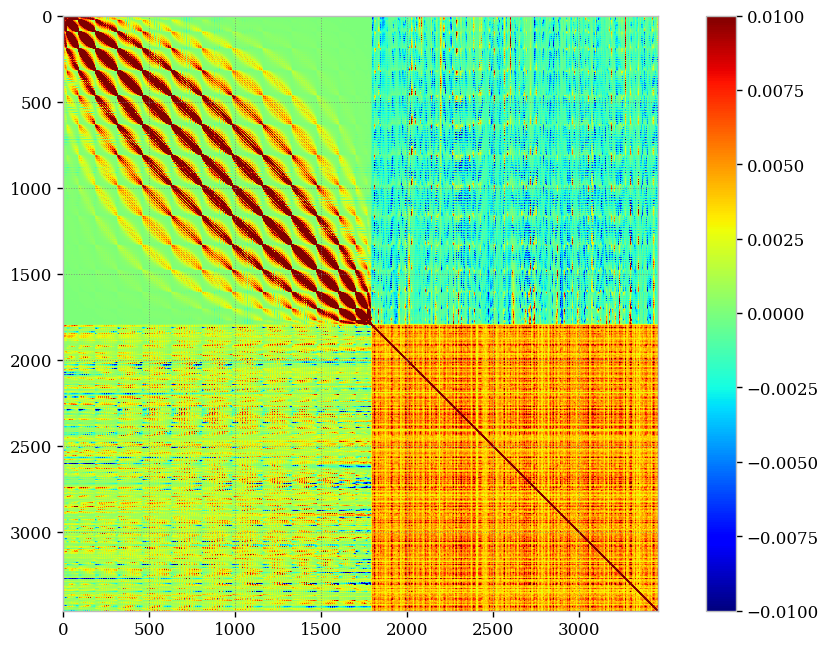

In [19]:
plot_utils.plot_correlation_from_likelihood(minuit_fitter_velest.likelihood,
                                            parameter_dict,
                                            vmin=-0.01,vmax=0.01)

/pscratch/sd/b/bastienc/Soft/.miniconda3/envs/flip/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


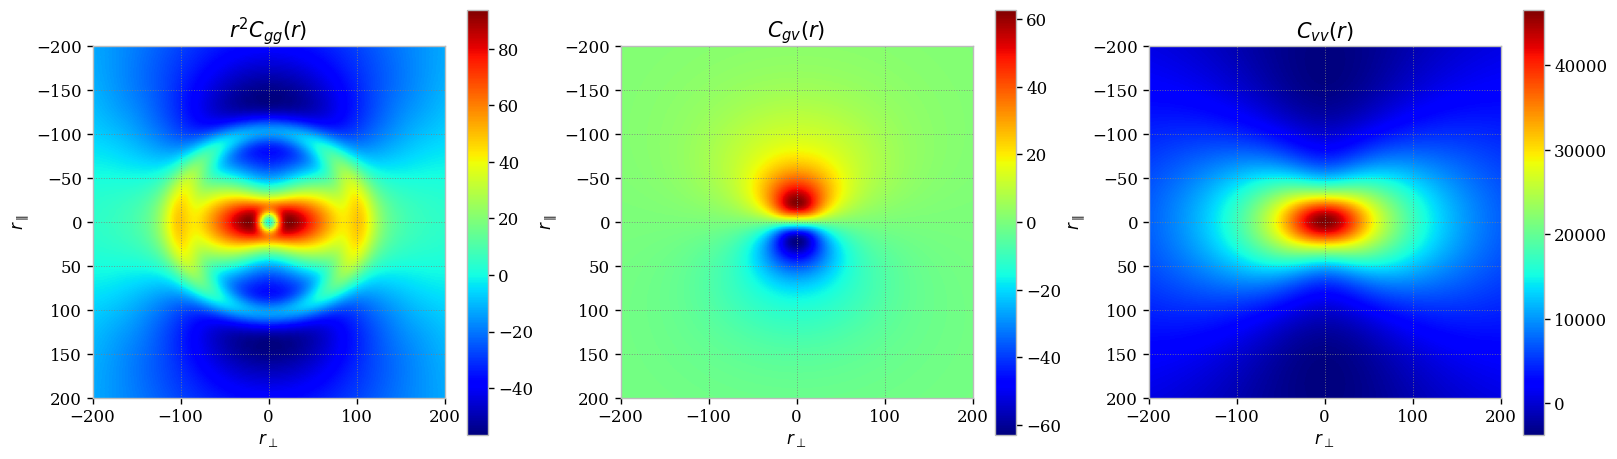

In [20]:

r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "adamsblake20",
    "full",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
    additional_parameters_values=(sigmag_fiducial,),
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}

plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)
